In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np


### policy paths

In [3]:
bart_policy_path = "./policy/bart-policy.csv"
base_policy_path = "./policy/base-policy.csv"
small_policy_path = "./policy/small-policy.csv"

policy_paths = [bart_policy_path, base_policy_path, small_policy_path]

### no policy paths

In [4]:
bart_no_policy_path = "./no-policy/bart_no_policy.csv"
base_no_policy_path = "./no-policy/base_no_policy.csv"
small_no_policy_path = "./no-policy/small_no_policy.csv"

no_policy_paths = [small_no_policy_path, base_no_policy_path, bart_no_policy_path]

In [5]:
# read the policy file as dataframe
df_test = pd.read_csv(bart_no_policy_path)

In [11]:
df_test.columns

Index(['energon_total_in_power_mW', 'energon_cpu_in_power_mW',
       'energon_gpu_in_power_mW', 'energon_cpu_total_usage_percentage',
       'energon_gpu_total_usage_percentage', 'energon_ram_used_percentage',
       'timestamp'],
      dtype='object')

In [ ]:
plt.plot(df_test[""])

In [6]:
def find_first_gpu_usage_higher_than_threshold(df, threshold):
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] > threshold:
            return i
    return -1

def find_last_gpu_usage_higher_than_threshold(df, threshold):
    result = -1
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] > threshold:
            result = i
        elif result != -1:
            return result
    
    return result

# check if df contains -1 in the column c
def check_for_minus_one(df, c):
    for i, row in df.iterrows():
        if row[c] == -1:
            return True
    return False

# count the number of missing values in the dataframe
def count_missing_values(df):
    count = 0
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] < 0 or row["energon_total_in_power_mW"] < 0:
            count += 1
    return count

In [85]:
count_missing_values(df_test)


59119

In [86]:
def interpolate_missing_values(df, spike_prob=0.05, spike_magnitude=4.0, local_noise_std=0.1, trend_length=100):
    # Create a copy of the dataframe with no missing values
    df_no_missing = df[(df["energon_gpu_total_usage_percentage"] > 0) & (df["energon_total_in_power_mW"] > 0)].copy()

    # Calculate mean and std dev for key columns
    time_diff = df_no_missing["timestamp"].diff().mean()
    time_diff_std = df_no_missing["timestamp"].diff().std()

    # Define columns to interpolate and their means/std deviations
    cols_to_interpolate = [
        "energon_total_in_power_mW", 
        "energon_cpu_in_power_mW", 
        "energon_gpu_in_power_mW",
        "energon_cpu_total_usage_percentage",
        "energon_gpu_total_usage_percentage",
        "energon_ram_used_percentage"
    ]
    col_means = df_no_missing[cols_to_interpolate].mean()
    col_stds = df_no_missing[cols_to_interpolate].std()

    # Fill missing values
    for i, row in df.iterrows():
        if row["energon_gpu_total_usage_percentage"] < 0 or row["energon_total_in_power_mW"] < 0:
            # Estimate timestamp with variable time difference
            if i > 0:
                prev_timestamp = df.at[i-1, "timestamp"]
                df.at[i, "timestamp"] = prev_timestamp + time_diff + random.uniform(-time_diff_std, time_diff_std)
            
            # Interpolate for each column
            for col in cols_to_interpolate:
                # Generate a base interpolated value with local noise
                interpolated_value = col_means[col] + np.random.normal(0, col_stds[col] / 2)

                # Decide if a spike will be added
                is_spike = random.random() < spike_prob
                if is_spike:
                    # Add a spike
                    spike_direction = random.choice([-1, 1])
                    interpolated_value += spike_direction * spike_magnitude * col_stds[col]

                    # Create a pre-spike trend
                    for j in range(trend_length):
                        if i - j - 1 >= 0:
                            trend_value = col_means[col] + (j / trend_length) * spike_direction * spike_magnitude * col_stds[col]
                            df.at[i - j - 1, col] = trend_value
                    
                    # Create a post-spike trend
                    for j in range(1, trend_length + 1):
                        if i + j < len(df):
                            trend_value = col_means[col] - (j / trend_length) * spike_direction * spike_magnitude * col_stds[col]
                            df.at[i + j, col] = trend_value

                elif random.random() < 0.5:
                    # Apply local noise to create short-term fluctuations around interpolated values
                    interpolated_value += np.random.normal(0, local_noise_std * col_stds[col])

                # Ensure percentages stay within realistic bounds (0-100)
                if 'percentage' in col:
                    interpolated_value = max(0, min(100, interpolated_value))
                
                # Set the interpolated value
                df.at[i, col] = interpolated_value

    # Optionally smooth interpolated series with a small rolling average to reduce extreme jumps
    # for col in cols_to_interpolate:
    #     df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
    #     df[col] = df[col].rolling(window=3, min_periods=1).mean()

    return df

In [87]:
df_interpolated = interpolate_missing_values(df_test)

In [122]:
df_interpolated_2 = df_interpolated[:len(df_interpolated)//2]

cols_to_interpolate = [
    "energon_total_in_power_mW", 
    "energon_cpu_in_power_mW", 
    "energon_gpu_in_power_mW",
    "energon_cpu_total_usage_percentage",
    "energon_gpu_total_usage_percentage",
    "energon_ram_used_percentage"
]

col_means = df_interpolated_2[cols_to_interpolate].mean()
col_stds = df_interpolated_2[cols_to_interpolate].std()



# divide df_interpolated into 10 chunks
chunks = np.array_split(df_interpolated_2, 50)

# concatenate the chunks randomly
random.shuffle(chunks)
df_interpolated_3 = pd.concat(chunks)

# add some random noise to the df_interpolated_2
for col in cols_to_interpolate:
    df_interpolated_3[col] += np.random.normal(0, col_stds[col] / 10, len(df_interpolated_3))

# smooth the interpolated series
for col in cols_to_interpolate:
    df_interpolated_3[col] = df_interpolated_3[col].fillna(method='ffill').fillna(method='bfill')
    df_interpolated_3[col] = df_interpolated_3[col].rolling(window=3, min_periods=1).mean()


df_interpolated_4 = pd.concat([df_interpolated_2, df_interpolated_3])


In [126]:

# save the interpolated dataframe
df_interpolated_4.to_csv("base_no_policy_interpolated.csv", index=False)

concatenated_df Index(['energon_total_in_power_mW', 'energon_cpu_in_power_mW',
       'energon_gpu_in_power_mW', 'energon_cpu_total_usage_percentage',
       'energon_gpu_total_usage_percentage', 'energon_ram_used_percentage',
       'timestamp'],
      dtype='object')


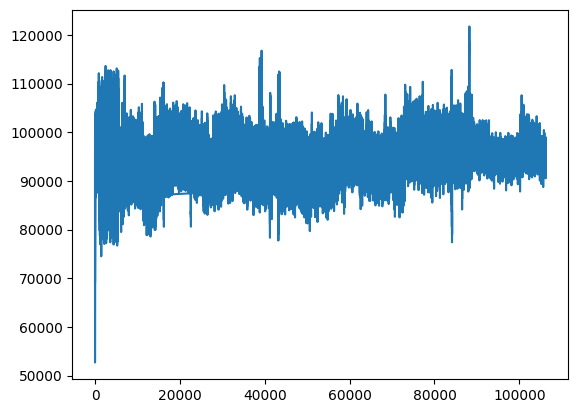

In [166]:
# read /home/matteo/Documents/apps/prometheus-2.37.8.linux-amd64/reports/no-policy/base_no_policy2.csv as dataframe
df_test1 = pd.read_csv("./no-policy/base_no_policy2.csv")
df_test1 = df_test1[(df_test1["energon_gpu_total_usage_percentage"] > 0) & (df_test1["energon_total_in_power_mW"] > 0) & (df_test1["energon_gpu_in_power_mW"] > 0)]

col_means = df_test1[cols_to_interpolate].mean()
col_stds = df_test1[cols_to_interpolate].std()

# add some random noise to the df_interpolated_2
for col in cols_to_interpolate:
    df_test1[col] += np.random.normal(0, col_stds[col] / 2, len(df_test1))

# smooth the interpolated series
for col in cols_to_interpolate:
    df_test1[col] = df_test1[col].fillna(method='ffill').fillna(method='bfill')
    df_test1[col] = df_test1[col].rolling(window=3, min_periods=1).mean()

concatenated_df = pd.concat([df_interpolated_4, df_test1])

# divide df_interpolated into 10 chunks
chunks = np.array_split(concatenated_df, 20)
random.shuffle(chunks)
concatenated_df = pd.concat(chunks)
concatenated_df = concatenated_df[(concatenated_df["energon_gpu_total_usage_percentage"] > 0) & (concatenated_df["energon_total_in_power_mW"] > 0) & (concatenated_df["energon_gpu_in_power_mW"] > 0)]


print("concatenated_df", concatenated_df.columns)

plt.plot(concatenated_df['energon_total_in_power_mW'])

In [167]:

# save the concatenated dataframe
concatenated_df.to_csv("base_no_policy_interpolated_concatenated.csv", index=False)

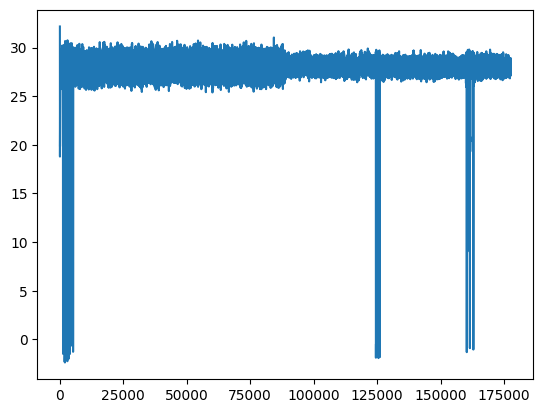

In [179]:
plt.plot(range(len(df_interpolated_4['energon_gpu_in_power_mW'])), df_interpolated_4['energon_gpu_in_power_mW'])

In [168]:
# read base_no_policy_interpolated_concatenated.csv
df_test3 = pd.read_csv("base_no_policy_interpolated_concatenated.csv")

In [172]:
# read policy/small-policy.csv
df_test4 = pd.read_csv(small_policy_path)
time_diff = df_test4["timestamp"].diff().mean()
time_diff_std = df_test4["timestamp"].diff().std()

timestamp = 0

for i, row in df_test3.iterrows():
    df_test3.at[i, "timestamp"] = timestamp
    timestamp += time_diff + random.uniform(-time_diff_std, time_diff_std)

In [174]:
df_test3.columns

Index(['energon_total_in_power_mW', 'energon_cpu_in_power_mW',
       'energon_gpu_in_power_mW', 'energon_cpu_total_usage_percentage',
       'energon_gpu_total_usage_percentage', 'energon_ram_used_percentage',
       'timestamp'],
      dtype='object')

In [182]:
for col in df_test3.columns:
    if "percentage" in col:
        df_test3[col] = df_test3[col].apply(lambda x: max(0, min(100, x)))

In [186]:
# save df_test3 
df_test3.to_csv("base_no_policy.csv", index=False)

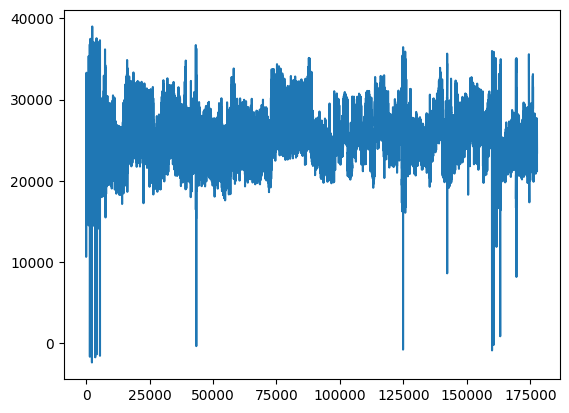

In [125]:
plt.plot(range(len(df_interpolated_4['energon_cpu_in_power_mW'])), df_interpolated_4['energon_cpu_in_power_mW'])

In [90]:
first_index = find_first_gpu_usage_higher_than_threshold(df_interpolated, 70)
last_index = find_last_gpu_usage_higher_than_threshold(df_interpolated, 70)

print("First index: ", first_index)
print("Last index: ", last_index)


First index:  50
Last index:  48804


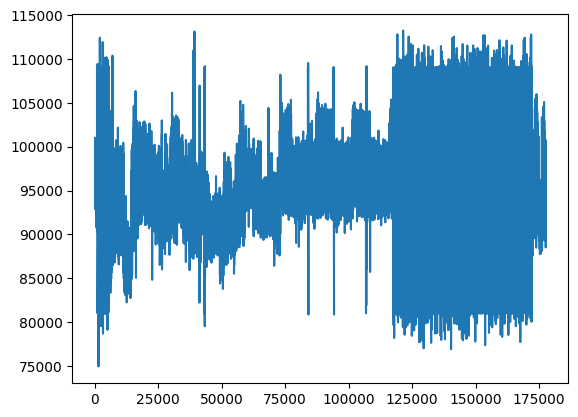

In [91]:
plt.plot(df_interpolated['energon_total_in_power_mW'][100:])

In [92]:
# create a copy of df_test from the first index to the last index
df_test_copy = df_test[first_index:last_index].copy()
# concatenate the copy with the interpolated dataframe


./policy/bart-policy.csv differece 2228.8450000286102
./policy/base-policy.csv differece 1584.233999967575
./policy/small-policy.csv differece 1154.37700009346


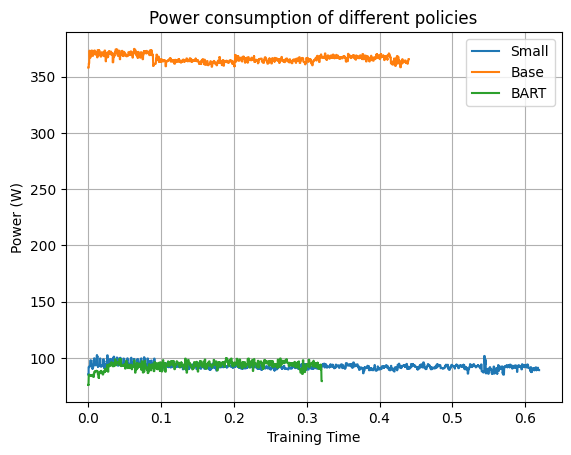

In [17]:
for df_path in policy_paths:
    df = pd.read_csv(df_path)

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    min_time_stamp = df["timestamp"].min()
    max_time_stap = df["timestamp"].max()

    print(df_path, "differece", max_time_stap - min_time_stamp)

    avg_time = df["timestamp"].diff().mean()
    std_time = df["timestamp"].diff().std()

    x_axis = []
    for i in range(len(energy_total)):
        x_axis.append(i * avg_time + random.uniform(-std_time, std_time))

    # x_axis is in seconds convert it to hours
    x_axis = [x / 3600 for x in x_axis]

    # show grid
    plt.grid(True)

    plt.plot(x_axis, energy_total)
    plt.legend(["Small", "Base", "BART"])
    plt.ylabel("Power (W)")
    plt.xlabel("Training Time")
    plt.title("Power consumption of different policies")


./no-policy/small_no_policy.csv differece 61404.05500006676
./no-policy/base_no_policy.csv differece 141987.64184201873
./no-policy/bart_no_policy.csv differece 47806.575000047684


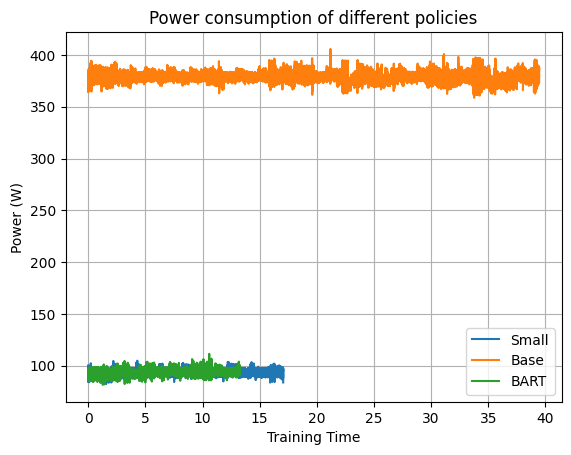

In [15]:
for df_path in no_policy_paths:
    df = pd.read_csv(df_path)

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    max_time_stap = df["timestamp"].max()
    min_time_stamp = df["timestamp"].min()

    print(df_path, "differece", max_time_stap - min_time_stamp)

    avg_time = df["timestamp"].diff().mean()
    std_time = df["timestamp"].diff().std()

    x_axis = []
    for i in range(len(energy_total)):
        x_axis.append(i * avg_time + random.uniform(-std_time, std_time))

    # x_axis is in seconds convert it to hours
    x_axis = [x / 3600 for x in x_axis]

    # show grid
    plt.grid(True)

    plt.plot(x_axis, energy_total)
    plt.legend(["Small", "Base", "BART"])
    plt.ylabel("Power (W)")
    plt.xlabel("Training Time")
    plt.title("Power consumption of different policies")


In [19]:
import numpy as np
from scipy.integrate import simps
from numpy import trapz

In [21]:
labels = []
trapz_energies = []
simps_energies = []
for df_path in no_policy_paths:
    df = pd.read_csv(df_path)

    labels.append(df_path.split("/")[2].split("_")[0])

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    trapz_energy = trapz(energy_total)
    simps_energy = simps(energy_total)

    trapz_energies.append(trapz_energy)
    simps_energies.append(simps_energy)

for df_path in policy_paths:
    df = pd.read_csv(df_path)

    labels.append(df_path.split("/")[2].split("-")[0])

    # filter worng values
    df = df[(df["energon_gpu_total_usage_percentage"] > 70) & (df["energon_total_in_power_mW"] > 0) & (df["energon_gpu_in_power_mW"] > 0)]

    energy_total = df['energon_total_in_power_mW'] / 1000
    if "base" in df_path:
        energy_total = energy_total + energy_total.mean() * 3

    trapz_energy = trapz(energy_total)
    simps_energy = simps(energy_total)

    trapz_energies.append(trapz_energy)
    simps_energies.append(simps_energy)




In [26]:
pow_value = 3
def custom_transform(x):
    r = np.power(x, 1/pow_value)
    # check if np r array containeys nan
    if np.isnan(r).any():
        # repplace nan with 0
        r = np.nan_to_num(r)
    return r

def custom_inverse_transform(x):
    return np.power(x, pow_value)

In [30]:
# Set the width of the bars
bar_width = 0.2

colors = ["lightblue", "#fad6a5", "#FF7276", "pink", "purple", "#E7D7AF", "#90EE90", "gray"]

# Position of bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.yticks([r + bar_width * 1.5 for r in range(len(labels))], labels)

plt.barh(r2, trapz_energies, height=bar_width, color=colors[0], edgecolor='black', label='Sent140 Simpson', hatch="/////")
plt.barh(r3, simps_energies, height=bar_width, edgecolor='black', label='MNIST Simpson', hatch="||||||")

plt.xlabel('Energy consumption [kJ]')

plt.gca().set_xscale("function", functions=[custom_transform, custom_inverse_transform])
x_ticks = np.arange(0, np.array(simps_energies).max(), 1000000)
plt.gca().set_xticks(x_ticks)
# plt.gca().set_xticks([0, 400, 1000, 2000, 3000, 5000, 6500])
# plt.gca().set_xticklabels([0, 400, 1000, 2000, 3000, 5000, 6500])




KeyboardInterrupt: 